## Initial value problems: Runge-Kutta methods

[Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) are improved versions of the Euler method that evaluates the derivative (i.e., $f(t, x)$) at more than one point and estimated point on the solution trajectory to improve the accuracy of the numerical methods. The [Runge-Kutta order 4 method](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods) described here is both simple to describe and a very good method! It is readily extended to an adaptive method that varies the step-size to reduce computation time while not sacrificing accuracy (called the Runge-Kutta-Fehlberg 45 method.)

I generally use the Tsit5 (Tsitouras 5/4 Runge-Kutta) method from the DifferentialEquations package as a first solver for a differential equation. This is an adaptive RK 4-5 method that also provides an interpolated solution between points where the solution is predicted.

For an overview of methods available in DifferentialEquations see this [documentation](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/).


The RK45 method is 

$$  \begin{split}
    k_1 &= hf(t_i,u_i), \\
    k_2 &= hf(t_i+h/2,u_i+k_1/2),\\
    k_3 &= hf(t_i+h/2,u_i+k_2/2),\\
    k_4 &= hf(t_i+h,u_i+k_3),\\
    u_{i+1} &= u_i + \frac{1}{6} k_1 + \frac{1}{3} k_2 + \frac{1}{3} k_3 + \frac{1}{6} k_4.
  \end{split} $$

which can summarized in the following table 
$$ \begin{array}{r|cccc}
    \rule{0pt}{2.75ex}0 &  & & & \\
    \rule{0pt}{2.75ex}\frac{1}{2} & \frac{1}{2} & & &\\
    \rule{0pt}{2.75ex}\frac{1}{2} & 0 & \frac{1}{2} & &\\
    \rule{0pt}{2.75ex}1 & 0 & 0 & 1\\[1mm] \hline
    \rule{0pt}{2.75ex}& \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
  \end{array} $$

The local truncation error (the error in a single step) is proportional to $h^5$. 
The local truncation error and coefficients $(1/6, 1/3, 1/3, 1/6)$ are obtained by repeated use of Taylor's theorem as shown the the derivation on [Wikipedia](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).

Here is a simple implementation from the textbook:
  

In [1]:
"""
    rk4(ivp,n)

Apply the common Runge-Kutta 4th order method to solve the given 
IVP using `n` time steps. Returns a vector of times and a vector of
solution values.
"""
function rk4(ivp,n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initialize output.
    u = fill(float(ivp.u0),n+1)

    # Time stepping.
    for i in 1:n
        k₁ = h*ivp.f( u[i],      ivp.p, t[i]     )
        k₂ = h*ivp.f( u[i]+k₁/2, ivp.p, t[i]+h/2 )
        k₃ = h*ivp.f( u[i]+k₂/2, ivp.p, t[i]+h/2 )
        k₄ = h*ivp.f( u[i]+k₃,   ivp.p, t[i]+h   )
        u[i+1] = u[i] + (k₁ + 2(k₂+k₃) + k₄)/6
    end
    return t,u
end

rk4

Here we solve the predator-prey problem again. First with RK45. Then Euler. Then Tsit5.

In [2]:
function predprey(u,p,t)
    α,β = p      # rename parameters for convenience
    y,z = u      # rename solution components
    s = (y*z) / (1+β*y)     # appears in both equations
    return [ y*(1-α*y) - s, -z + s ]
end;

u₀ = [1,0.01]
tspan = (0.,60.)
α,β = 0.1,0.25

using DifferentialEquations
ivp_pp = ODEProblem(predprey,u₀,tspan,[α,β]);

In [3]:
t1, u1 = rk4(ivp_pp, 1000); # target h should be eps()^(1/5), or smaller if a larger error can be tolerated
u1_prey = [ x[1] for x in u1 ]
u1_predator = [ x[2] for x in u1 ];

In [4]:
60/eps(8.0)^(1/5) # possible value of n

53486.62660891388

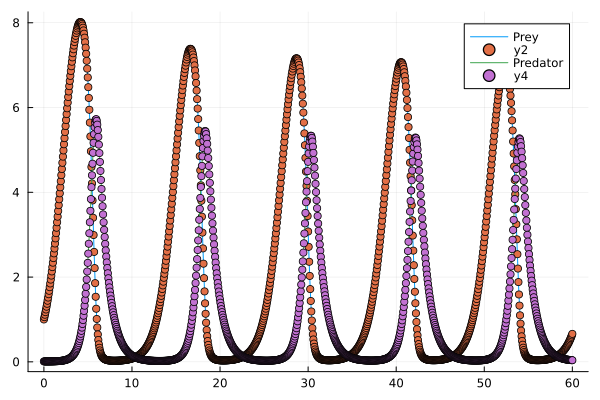

In [5]:
using Plots
plot(t1, u1_prey, label = "Prey")
scatter!(t1, u1_prey)
plot!(t1, u1_predator, label = "Predator")
scatter!(t1, u1_predator)

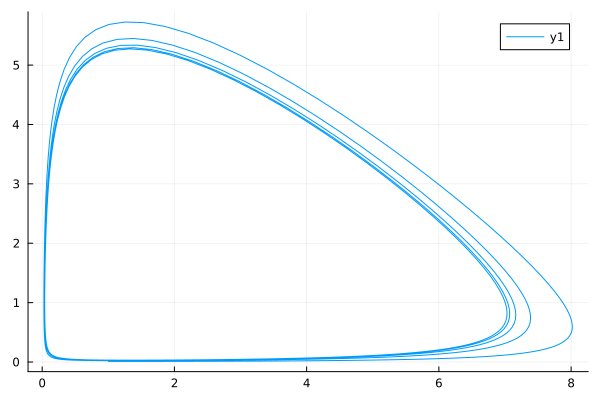

In [6]:
plot(u1_prey, u1_predator)

In [7]:
"""
    euler(ivp,n)

Apply Euler's method to solve the given IVP using `n` time steps.
Returns a vector of times and a vector of solution values.
"""
function euler(ivp,n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initial condition and output setup.
    u = fill(float(ivp.u0),n+1)

    # The time stepping iteration.
    for i in 1:n
        u[i+1] = u[i] + h*ivp.f(u[i],ivp.p,t[i])
    end
    return t,u
end

euler

In [8]:
t2, u2 = euler(ivp_pp, 500); # target h should be sqrt(eps())
u2_prey = [ x[1] for x in u2 ]
u2_predator = [ x[2] for x in u2 ];

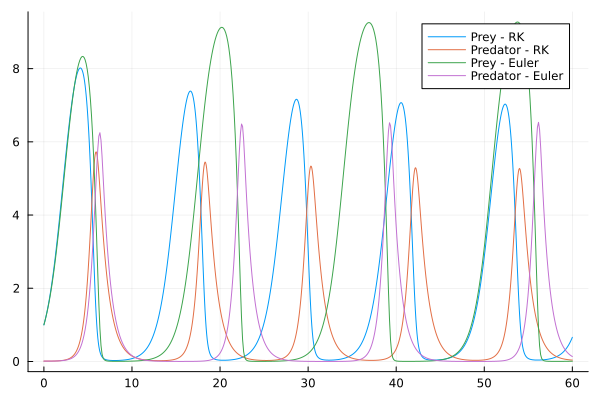

In [9]:
plot(t1, u1_prey, label = "Prey - RK")
plot!(t1, u1_predator, label = "Predator - RK")
plot!(t2, u2_prey, label = "Prey - Euler")
plot!(t2, u2_predator, label = "Predator - Euler")

We see there are major differences in the timing of oscillations depending on whether you use Euler or RK45 method.

Now we compare RK45 with the Tsit5 method.

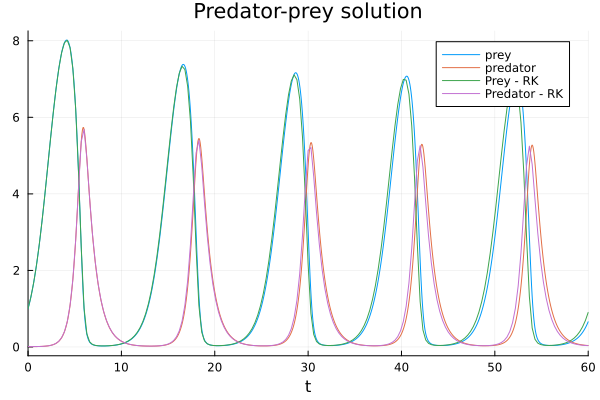

In [30]:
sol = solve(ivp_pp, Tsit5(), abstol = 1e-15);  # abstol = 1e-6 default
plot(sol,label=["prey" "predator"], title="Predator-prey solution")
plot!(t1, u1_prey, label = "Prey - RK")
plot!(t1, u1_predator, label = "Predator - RK")

No apparent difference! Not surprising since they share a common core part of the algorithm. The difference is that Tsit5 is adaptive, so it takes unequally-spaced steps and attempts to automatically control the error. Let's compute the difference between the two methods.

The Tsit5 output is a function that will evaluate the solution at any time. So we start by computing the solution at the same times we used for RK45.

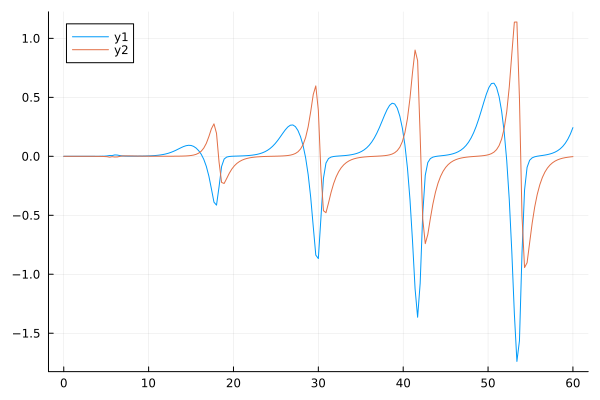

In [31]:
u3_prey = [ sol(t)[1] for t in t1 ];
u3_predator = [ sol(t)[2] for t in t1 ];
error_prey = u1_prey .- u3_prey;
error_predator = u1_predator .- u3_predator;
plot(t1, error_prey)
plot!(t1, error_predator)

Does this error get smaller if we put more points into the RK45 solution? (Yes between roughly 50-500 points for RK45 but not much when more points are added.)

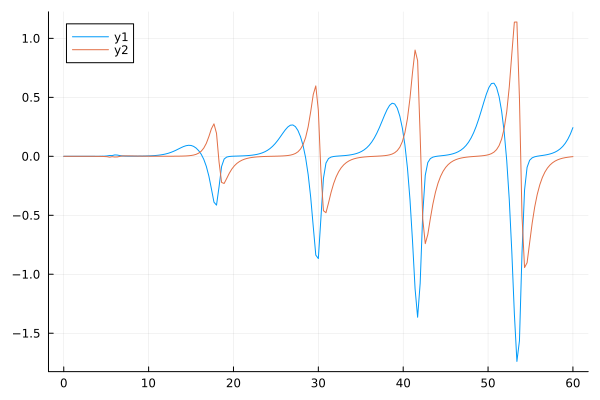

In [32]:
t1, u1 = rk4(ivp_pp, 200);
u1_prey = [ x[1] for x in u1 ]
u1_predator = [ x[2] for x in u1 ];
u3_prey = [ sol(t)[1] for t in t1 ];
u3_predator = [ sol(t)[2] for t in t1 ];
error_prey = u1_prey .- u3_prey;
error_predator = u1_predator .- u3_predator;
plot(t1, error_prey)
plot!(t1, error_predator)

Tsit5 is an adaptive RK4/5 method. Here we can see the places where the solution was determined. Tsit5 reports 100 samples, compared to the 500 samples we used for RK4.

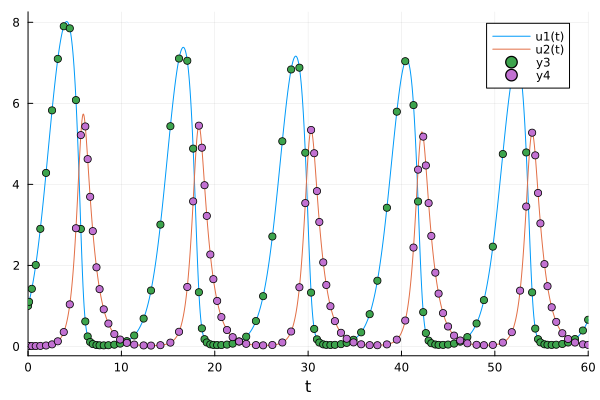

In [33]:
plot(sol)
scatter!(sol.t, [ x[1] for x in sol.u])
scatter!(sol.t, [ x[2] for x in sol.u])

## Adaptive Runge-Kutta

The details are in Section 6.5. Here's the basic idea.

* Make two predictions of a single time step from $(t_k, u_k)$ to $(t_{k+1}, u_{k+1})$
* Obtain an error estimate
* If the error is small, increase the step size; if large, shrink the step size and recompute the step

The textbook does this for a RK order 2-3 method; this is also commonly done with the RK45 method.

In [14]:
using LinearAlgebra
"""
    rk23(ivp,tol)

Apply an adaptive embedded RK formula pair to solve given IVP with
estimated error `tol`. Returns a vector of times and a vector of
solution values.
"""
function rk23(ivp,tol)
    # Initialize for the first time step.
    a,b = ivp.tspan
    t = [a]
    u = [float(ivp.u0)];   i = 1;
    h = 0.5*tol^(1/3)
    s₁ = ivp.f(ivp.u0,ivp.p,a)

    # Time stepping.
    while t[i] < b
        # Detect underflow of the step size.
        if t[i]+h == t[i]
            @warn "Stepsize too small near t=$(t[i])"
            break  # quit time stepping loop
        end

        # New RK stages.
        s₂ = ivp.f( u[i]+(h/2)*s₁,   ivp.p, t[i]+h/2   )
        s₃ = ivp.f( u[i]+(3h/4)*s₂, ivp.p, t[i]+3h/4 )
        unew2 = u[i] + h*(2s₁  + 3s₂ + 4s₃)/9   # 2rd order solution
        s₄ = ivp.f( unew2, ivp.p, t[i]+h )
        err = h*(-5s₁/72 + s₂/12 + s₃/9 - s₄/8)  # 2nd/3rd difference
        E = norm(err,Inf)                         # error estimate
        maxerr = tol*(1 + norm(u[i],Inf))     # relative/absolute blend

        # Accept the proposed step?
        if E < maxerr     # yes
            push!(t,t[i]+h)
            push!(u,unew2)
            i += 1
            s₁ = s₄       # use FSAL property
        end

        # Adjust step size.
        q = 0.8*(maxerr/E)^(1/3)   # conservative optimal step factor
        q = min(q,4)               # limit stepsize growth
        h = min(q*h,b-t[i])        # don't step past the end
    end
    return t,u
end

rk23

This method shows how adaptive time steps can save a lot of computation with the following example.

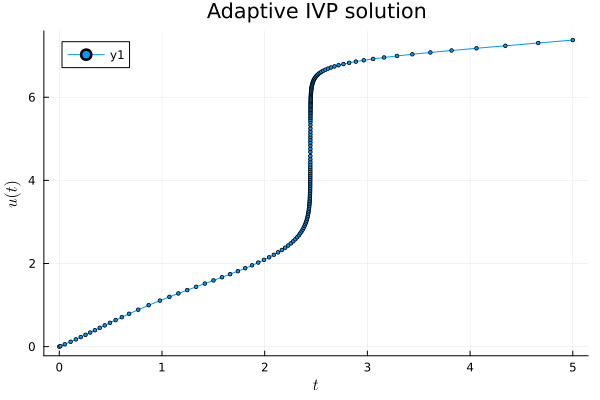

In [15]:
using LaTeXStrings
f0 = (u,p,t) -> exp(t-u*sin(u))
ivp0 = ODEProblem(f0, 0, (0.,5.))
t,u = rk23(ivp0, 1e-5)

plot(t,u,m=2,
    xlabel=L"t",ylabel=L"u(t)",title="Adaptive IVP solution")


Here's the step size used by the method, as a function of time.

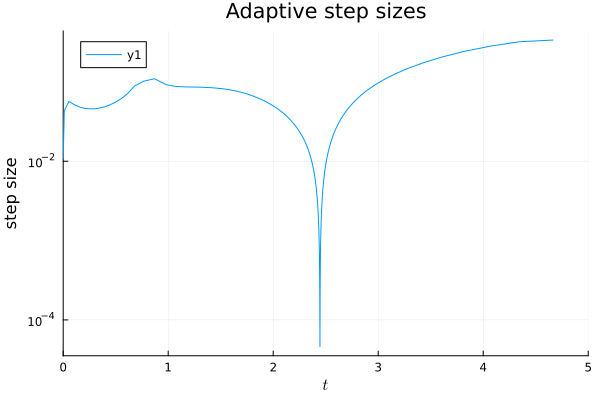

In [16]:
Δt = diff(t)
plot(t[1:end-1], Δt, title="Adaptive step sizes",
    xaxis=(L"t",(0,5)),yaxis=(:log10,"step size"))

Using the minimum step size (roughly $5\cdot 10^{-5}$) for the whole solution would require more than 100,000 steps, compared to the 157 actually used by the method.

In [17]:
minimum(Δt), 5/minimum(Δt), size(t)

(4.6096854609878335e-5, 108467.27053972406, (157,))

Here is the RK23 method applied to our predator-prey system.

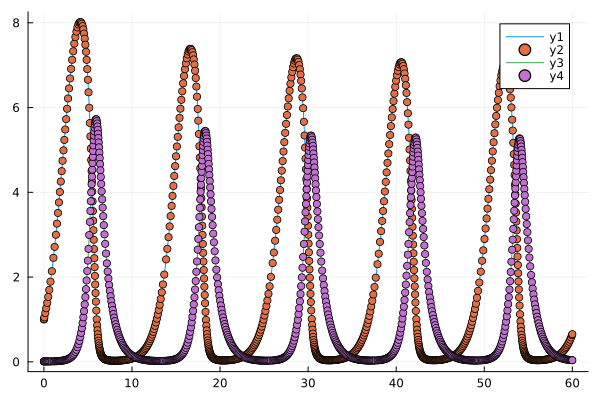

In [34]:
t4, u4 = rk23(ivp_pp, 1e-5);
u4_prey = [ x[1] for x in u4 ]
u4_predator = [ x[2] for x in u4 ];
plot(t4, u4_prey)
scatter!(t4, u4_prey)
plot!(t4, u4_predator)
scatter!(t4, u4_predator)

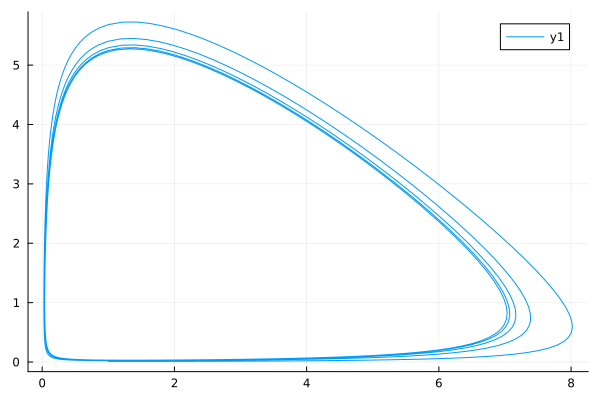

In [35]:
plot(u4_prey, u4_predator)

In [37]:
# How many time steps?
size(u4_prey)

(702,)

## Other methods

Multi-step methods (section 6.6-6.7) use solutions already computed from before $t_k, u_k$ as part of the algorithm to compute future time steps.

A simple example is a one-step implicit method. Here is a simple example built from the Euler method (backward Euler).

Instead of writing $u_{k+1} = u_k + hf(t_k, u_k)$ we write $u_{k+1} = u_k + hf(t_{k+1}, u_{k+1})$.

As a simple example, solve $x'(t) = \lambda x$ using this method.

Write $u_{k+1} = u_k + h\lambda u_{k+1}$ and solve to get 
$u_{k+1} = \frac{u_k}{1-h\lambda}$.

In [1]:
a, b = 0, 1
N = 100
h = (b-a)/N
t = range(a, b, length = N)
backward = zeros(N)
forward = zeros(N)
lambda = 1.5
backward[1] = 2.0
forward[1] = 2.0
for i in 2:N
    backward[i] = backward[i-1] / (1-h*lambda)
    forward[i] = forward[i-1] + h*lambda*forward[i-1]
end

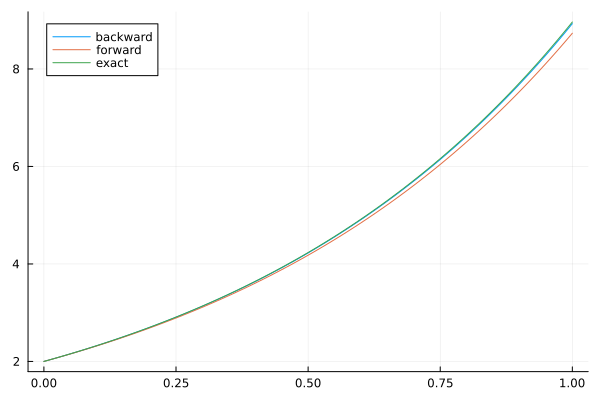

In [3]:
using Plots
exact = forward[1] * exp.(t .* lambda)
plot(t, backward, label = "backward")
plot!(t, forward, label = "forward")
plot!(t, exact, label = "exact")

Look at the errors.

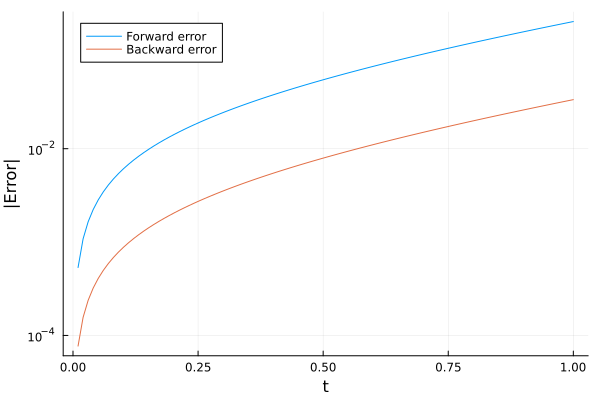

In [6]:
f_error= abs.(forward - exact)
b_error= abs.(backward - exact)
plot(t[2:end], f_error[2:end], label = "Forward error")
plot!(t[2:end], b_error[2:end], label = "Backward error",
yscale = :log10, xlabel = "t", ylabel = "|Error|")

Of course, you can't solve the implicit equation algebraically in general, so we use root finding (levenberg). Here is the next method more complex than backward Euler, an implicit method using solutions at two time steps.

In [7]:
include("fnc.jl");

In [8]:
"""
    am2(ivp,n)

Apply the Adams-Moulton 2nd order method to solve given IVP using
`n` time steps. Returns a vector of times and a vector of
solution values.
"""
function am2(ivp,n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initialize output.
    u = fill(float(ivp.u0),n+1)

    # Time stepping.
    for i in 1:n
        # Data that does not depend on the new value.
        known = u[i] + h/2*ivp.f(u[i],ivp.p,t[i])
        # Find a root for the new value.
        g = z -> z - h/2*ivp.f(z,ivp.p,t[i+1]) - known
        unew = levenberg(g,known)
        u[i+1] = unew[end]
    end
    return t,u
end

am2

We solve a "stiff" problem with this method and the RK4 method.

Incidentally the exact solution to this problem involves the Lambert W function: $u(t) = \frac{1}{1+ W((h-1)e^{h-t-1})}$ where $u(0) = 1/h$.

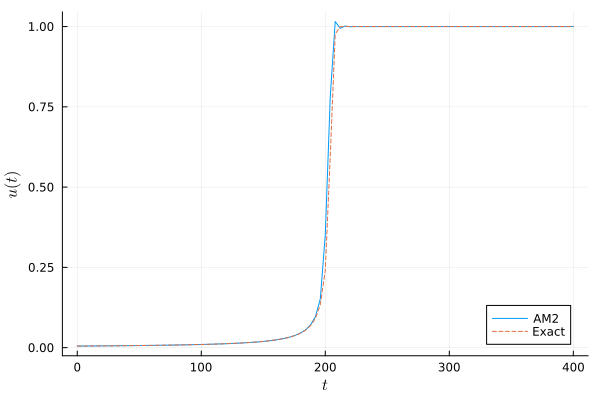

In [12]:
using DifferentialEquations, LinearAlgebra, LaTeXStrings
ivp_stiff = ODEProblem((u,p,t)->u^2-u^3, 0.005, (0,400.))
tI,uI = am2(ivp_stiff, 100)

using LambertW
h = 1/0.005
uExact = @. 1/(1+lambertw((h-1)*exp(h-tI-1)))

plot(tI, uI, label="AM2",
    xlabel=L"t", ylabel=L"u(t)", legend=:bottomright)
plot!(tI, uExact, label = "Exact", linestyle = :dash)

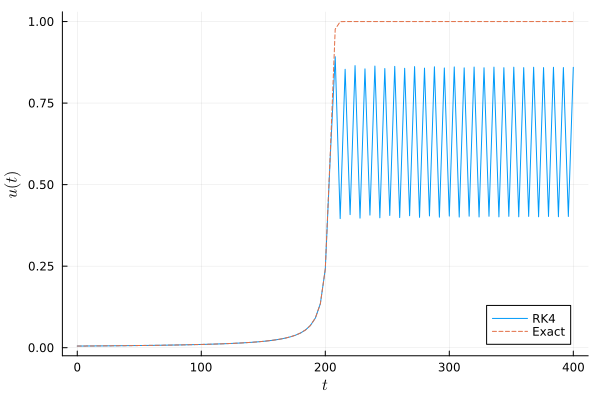

In [13]:
tI2, uI2 = rk4(ivp_stiff, 100)

plot(tI2, uI2, label="RK4",
    xlabel=L"t", ylabel=L"u(t)", legend=:bottomright)
plot!(tI, uExact, label = "Exact", linestyle = :dash)

It's easy to get even worse solutions from RK4 using larger time steps.

Here is the classic example of a "stiff" system with exact solution
$x(t) = 2e^{-t} - e^{-1000t}$, $y(t) = -e^{-t} + e^{-1000t}$

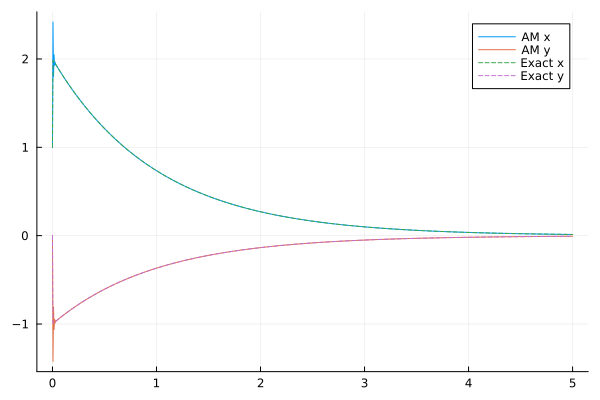

In [14]:
function stiff(u, p, t)
    x, y = u
    [ 998 * x + 1998 * y, -999 * x - 1999 * y]
end
ivp2 = ODEProblem(stiff, [1.0, 0.0], (0,5.))
tS1,uS1 = am2(ivp2,1000)
tS2,uS2 = rk4(ivp2,1000)
uS1_x = [ x[1] for x in uS1 ]
uS2_x = [ x[1] for x in uS2 ]
uS1_y = [ x[2] for x in uS1 ]
uS2_y = [ x[2] for x in uS2 ]
exact_x = @. 2*exp(-tS1) - exp(-1000*tS1)
exact_y = @. -exp(-tS1) + exp(-1000*tS1)
plot(tS1, uS1_x, label = "AM x")
plot!(tS1, uS1_y, label = "AM y")
plot!(tS1, exact_x, label = "Exact x", linestyle= :dash)
plot!(tS1, exact_y, label = "Exact y", linestyle = :dash)

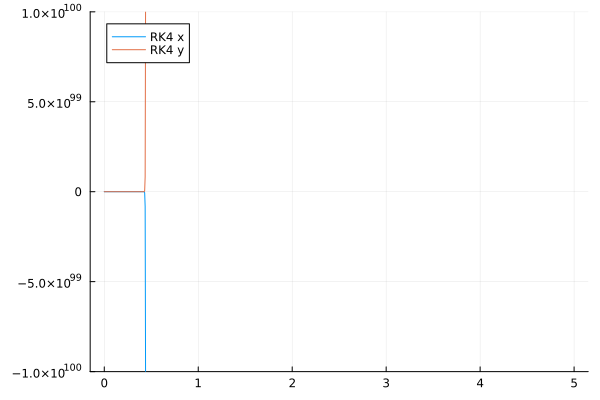

In [15]:
plot(tS2, uS2_x, label = "RK4 x")
plot!(tS2, uS2_y, label = "RK4 y", ylims = (-1e100, 1e100))

Finally, let's try the adaptive Tsit5 method.

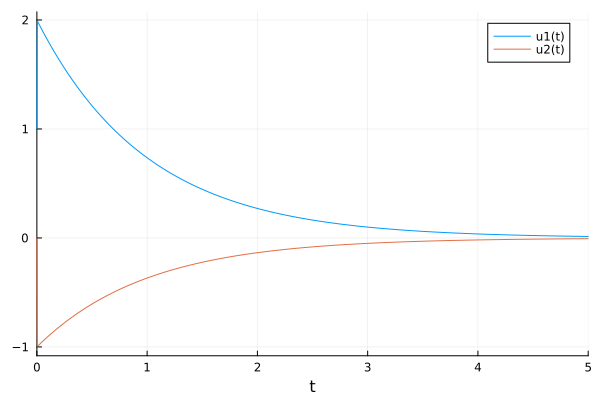

In [16]:
sol_stiff = solve(ivp2, Tsit5())
plot(sol_stiff)

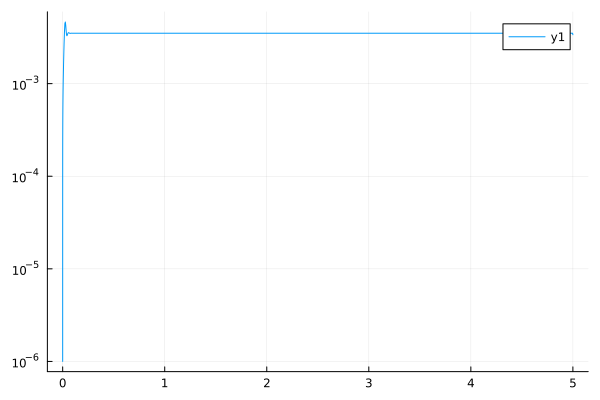

In [23]:
plot(sol_stiff.t[2:end], diff(sol_stiff.t), yscale = :log10)

Recommendations for solving a wide range of problems: Tsit5 and if that fails, Rosenbrock23. See https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/

Rosenbrock is an adaptive, implicit solver from the Runge-Kutta family.

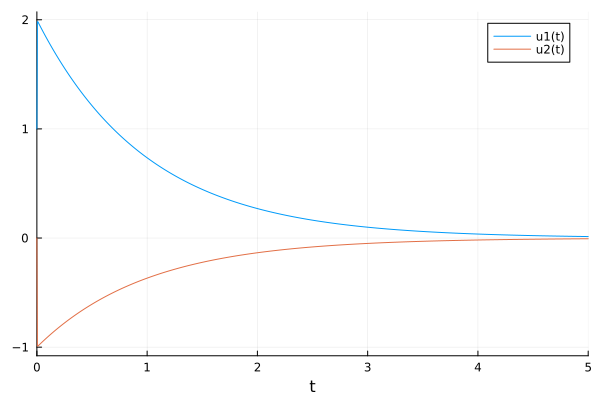

In [19]:
sol_stiff2 = solve(ivp2, Rosenbrock23())
plot(sol_stiff2)

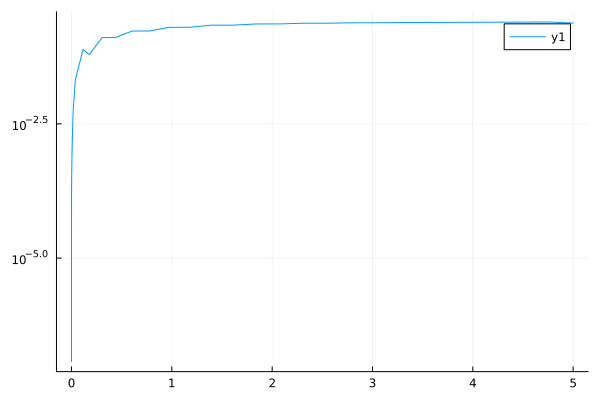

In [22]:
plot(sol_stiff2.t[2:end], diff(sol_stiff2.t), yscale = :log10)